In [ ]:
from calibration_sql_type_reader import TypeTopLogitFormatSequenceReader

from calibration_metric.vis.calibration_plot import plot_df
from calibration_metric import ECEMetric

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns 

metric = ECEMetric(binning_strategy="adaptive", return_df=True)

spider_paths_and_models = [("/brtx/604-nvme2/estengel/calflow_calibration/benchclamp/1.0/t5-small-lm-adapt_spider_past_none_db_val_all_0.0001/checkpoint-10000//outputs/test_all.logits",
                            "t5-small", "t5-small"),
                            ("/brtx/604-nvme2/estengel/calflow_calibration/benchclamp/1.0/t5-base-lm-adapt_spider_past_none_db_val_all_0.0001/checkpoint-10000//outputs/test_all.logits",
                            "t5-base", "t5-base"),
                            ("/brtx/604-nvme2/estengel/calflow_calibration/benchclamp/1.0/t5-large-lm-adapt_spider_past_none_db_val_all_0.0001/checkpoint-10000/outputs/test_all.logits", 
                             "t5-large",  "t5-large"),
                            ("/brtx/604-nvme2/estengel/calflow_calibration/benchclamp/1.0/bart-base_spider_past_none_db_val_all_0.0001/checkpoint-5000/outputs/test_all.logits",
                            "facebook/bart-base", "facebook/bart-base"),
                            ("/brtx/604-nvme2/estengel/calflow_calibration/benchclamp/1.0/bart-large_spider_past_none_db_val_all_0.0001/checkpoint-5000/outputs/test_all.logits",
                            "facebook/bart-large", "facebook/bart-large"),
                            ("/brtx/604-nvme2/estengel/calflow_calibration/benchclamp/1.0/codet5-base_spider_past_none_db_val_all_0.0001/checkpoint-10000/outputs/test_all.logits",
                            "Salesforce/codet5-base", "Salesforce/codet5-base"),
                            ("/home/estengel/semantic_parsing_with_constrained_lm/src/semantic_parsing_with_constrained_lm/trained_models/1.0/t5-small-lm-adapt_spider_past_none_db_val_all_lower_0.0001/checkpoint-5000/outputs/test_all_lower.logits",
                            "t5-small", "t5-small-lower")]


ece_df = []

fig, axs = plt.subplots(7, 3, figsize=(5, 8.5), sharex=True, sharey=True)
for i, (path, model, real_model) in enumerate(spider_paths_and_models):

    reader = TypeTopLogitFormatSequenceReader(path,
                                              model_name=model)
    preds_by_type, is_correct_by_type = reader.read()

    is_correct_by_type[0]

    types = ['other', 'Function', 'Column', 'Value']


    metric_value_kws = {"x": 0.3, "y":0.1}
    print(real_model)
    for j, type_idx in enumerate([1, 2, 3]): 

        print(f"type: {type_idx}: {len(preds_by_type[type_idx])}")
        ece, df = metric(preds_by_type[type_idx], is_correct_by_type[type_idx])
        ece *= 100
        model_name = real_model.split("/")[-1]

        ece_df.append({"model": model_name, "type": types[type_idx], "ece": ece})
        if i == 0:
            title = types[type_idx]
        else:
            title = None
        plot_df(df, 
            title=title,
            show_legend=False, 
            metric_value=ece, 
            xlabel="Acc",
            ylabel=model_name,
            ax=axs[i,j],
            metric_value_kwargs=metric_value_kws)



<Axes.ArtistList of 21 patches>


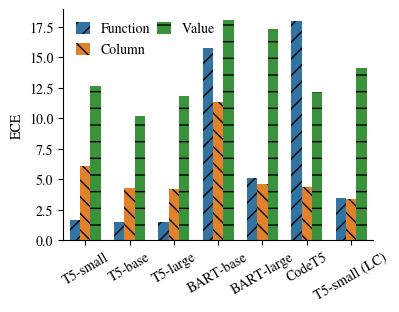

In [44]:
from matplotlib import pyplot as plt 
import itertools


plt.rcParams["font.family"] = "Nimbus Roman"

import pandas as pd
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

df = pd.DataFrame(ece_df)
sns.barplot(data=df, x="model", y="ece", hue="type", ax=ax, width=0.7) 
ax.set_ylabel("ECE")
ax.set_xlabel("")
sns.despine()

# hatches = itertools.cycle(['/', '\\', '-', '/', '\\,', '-'])
hatches = ['//', '\\\\', '-'] # , '/', '\\', '-', '/', '\\', '-', '/', '\\', '-', '/', '\\', '-', '/', '\\', '-', '/', '\\', '-', '/', '\\', '-', '/', '\\', '-', '/', '\\', '-', '/', '\\', '-'] # , '/', '\\,', '-'])
print(ax.patches)
for i, bars in enumerate(ax.containers):
    for j, bar in enumerate(bars):
        hatch = hatches[i]
        # hatch = next(hatches)
        bar.set_hatch(hatch)


ax.legend(ncol=2, frameon=False, handlelength=1, handleheight=1, columnspacing=0.5) 
ax.set_xticklabels(["T5-small", "T5-base", "T5-large", "BART-base", "BART-large", "CodeT5", "T5-small (LC)"], rotation=30)


plt.savefig("/home/estengel/papers/calibration-parsing-2023/figures/sql_ece_by_token_type.pdf", bbox_inches='tight') 
